In [130]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cmasher as cmr # for color maps

pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [131]:
with open('../models/config.json', 'r') as f:
    config = json.load(f)

postprocess = config['postprocessing']


In [132]:
# Output path
OUTPUT_PATH = postprocess['output_path']

# Input path
INPUT_PATH_S = postprocess['input_path_s']
INPUT_PATH_D = postprocess['input_path_d']

In [133]:
# Select the Date
DATE = 20230614

# Add period
PERIOD = 0 # 0: day, 1: week, 2: month

In [134]:
# Zuordnung der Periode zu einem String
period_dict = {0: 'day', 1: 'week', 2: 'month'}
PERIOD_STR = period_dict[PERIOD]

In [135]:
def load_deterministic_data(input_path, date, period_str):
    """
    Lädt die deterministischen Daten, behält den ursprünglichen 't'-Index bei und fügt eine 'timestamp'-Spalte hinzu.
    
    Parameters:
    - input_path: Pfad zu den deterministischen CSV-Dateien
    - date: Startdatum im Format YYYYMMDD
    - period_str: Periode als String ('day', 'week', 'month')
    
    Returns:
    - df: DataFrame mit ursprünglichem 't'-Index und 'timestamp'-Spalte
    """
    filename = f'd_{date}_to_{date}_{period_str}_ts.csv'
    file_path = os.path.join(input_path, filename)
    
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        # Spaltennamen bereinigen
        df.columns = df.columns.str.strip().str.replace(' ', '')
        
        # Überprüfen, ob 't' in den Spalten ist
        if 't' in df.columns:
            df.set_index('t', inplace=True)
        else:
            print(f"'t' Spalte nicht in {filename} gefunden.")
            return pd.DataFrame()
        
        # Berechnung des Startdatums
        start_datetime = pd.to_datetime(str(date), format='%Y%m%d')
        
        # Überprüfen des minimalen 't'-Werts
        min_t = df.index.min()
        if min_t == 1:
            # 't' beginnt bei 1, daher 1 subtrahieren
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index - 1, unit='h')
        else:
            # 't' beginnt bei 0 oder einem anderen Wert
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index, unit='h')
        
        return df
    else:
        print(f"Deterministische Datei {filename} nicht im Pfad {input_path} gefunden.")
        return pd.DataFrame()


In [136]:
def load_stochastic_data(input_path, date, period_str):
    """
    Lädt die stochastischen Daten, sortiert die Szenarien numerisch, behält den ursprünglichen 't'-Index bei und fügt eine 'timestamp'-Spalte hinzu.
    
    Parameters:
    - input_path: Pfad zu den stochastischen CSV-Dateien
    - date: Startdatum im Format YYYYMMDD
    - period_str: Periode als String ('day', 'week', 'month')
    
    Returns:
    - combined_df: Kombinierter DataFrame mit ursprünglichem 't'-Index, 'timestamp'-Spalte und sortierten Szenarien
    """
    # Regex-Muster zum Extrahieren der Dateiinformationen
    pattern = re.compile(r's_(.*?)_(\d+)_to_(\d+)_(.*?)_ts\.csv')
    stochastic_files = []

    # Durchsuchen des Verzeichnisses nach passenden Dateien
    for f in os.listdir(input_path):
        if f.startswith('s_') and f.endswith('_ts.csv'):
            match = pattern.match(f)
            if match:
                scenario = match.group(1)
                start_date = match.group(2)
                end_date = match.group(3)
                period_in_file = match.group(4)
                if start_date == str(date) and period_in_file == period_str:
                    stochastic_files.append((f, scenario, start_date, end_date))
    
    if not stochastic_files:
        print("Keine passenden stochastischen Dateien gefunden.")
        return pd.DataFrame()
    
    # Sortieren der stochastic_files nach Szenariennummer
    def extract_scenario_number(scenario):
        # Extrahiert die erste gefundene Zahl aus dem Szenarionamen
        numbers = re.findall(r'\d+', scenario)
        return int(numbers[0]) if numbers else float('inf')
    
    stochastic_files_sorted = sorted(stochastic_files, key=lambda x: extract_scenario_number(x[1]))
    
    # Extrahieren von start_date und end_date aus der ersten Datei
    _, _, start_date, end_date = stochastic_files_sorted[0]
    start_datetime = pd.to_datetime(str(start_date), format='%Y%m%d')
    end_datetime = pd.to_datetime(str(end_date), format='%Y%m%d') + pd.Timedelta(hours=23)
    
    # Berechnen der Gesamtanzahl der Stunden
    total_hours = int((end_datetime - start_datetime).total_seconds() // 3600) + 1  # +1 für inklusive Enddatum
    
    # Initialisieren des kombinierten DataFrames
    combined_df = pd.DataFrame()
    
    # Laden und Kombinieren der stochastischen Daten in der sortierten Reihenfolge
    for filename, scenario, _, _ in stochastic_files_sorted:
        file_path = os.path.join(input_path, filename)
        df = pd.read_csv(file_path)
        # Spaltennamen bereinigen
        df.columns = df.columns.str.strip().str.replace(' ', '')
        
        # Überprüfen, ob 't' in den Spalten ist
        if 't' in df.columns:
            df.set_index('t', inplace=True)
        else:
            print(f"'t' Spalte nicht in {filename} gefunden.")
            continue
        
        # Überprüfen der Anzahl der Zeilen
        if len(df) != total_hours:
            print(f"Die Anzahl der Zeilen in {filename} ({len(df)}) stimmt nicht mit der erwarteten Anzahl ({total_hours}) überein.")
            continue
        
        # Überprüfen des minimalen 't'-Werts
        min_t = df.index.min()
        if min_t == 1:
            # 't' beginnt bei 1, daher 1 subtrahieren
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index - 1, unit='h')
        else:
            # 't' beginnt bei 0 oder einem anderen Wert
            df['timestamp'] = start_datetime + pd.to_timedelta(df.index, unit='h')
        
        # Hinzufügen des Szenarionamens als Präfix zu den Spalten (außer 'timestamp')
        data_columns = df.columns.tolist()
        data_columns.remove('timestamp')
        df = df.rename(columns=lambda x: f'{scenario}_{x}' if x != 'timestamp' else x)
        
        # Kombinieren der Daten
        combined_df = pd.concat([combined_df, df], axis=1)
    
    return combined_df


In [137]:
# Create DataFrames
df_deterministic = load_deterministic_data(INPUT_PATH_D, DATE, PERIOD_STR)
df_stochastic = load_stochastic_data(INPUT_PATH_S, DATE, PERIOD_STR)

In [145]:
df_stochastic.head()
df_stochastic.to_csv('stochastic.csv')

In [139]:
fontsize_label = 16
fontsize_ticks = 14
fontsize_title = 18

# Function to set axis properties
def set_axis_properties(ax, title, ylabel, xlabel, fontsize_title, fontsize_label):
    ax.grid()
    ax.set_title(title, fontsize=fontsize_title)
    ax.set_ylabel(ylabel, fontsize=fontsize_label)
    ax.set_xlabel(xlabel, fontsize=fontsize_label)
    ax.legend(loc=1, fontsize=fontsize_ticks)
   
    ax.set_xticks(range(0, 25, 4))
    ax.set_xticklabels(range(0, 25, 4))
    ax.set_xlim([0, 24])
    ax.tick_params(axis='both', labelsize=fontsize_ticks)


# Assign fixed colors for global parameters
global_params = ['heat_price', 'gas_price']
scenarios = ['Scenario1', 'Scenario2', 'Scenario3', 'Scenario4', 'Scenario5']

# Generate colors using cmasher colormap for scenarios
color_mapping = {}
num_scenarios = len(scenarios)
scenario_colors = cmr.take_cmap_colors('cmr.chroma', N=num_scenarios, cmap_range=(0.3, 0.9))

# Assign colors to scenarios (using cmasher)
for i, scenario in enumerate(scenarios):
    color_mapping[scenario] = scenario_colors[i]

# Fixed color for global parameters
color_mapping['HEAT_PRICE'] = 'red'
color_mapping['GAS_PRICE'] = 'orange'
color_mapping['POWER_PRICE'] = 'blue'
color_mapping['predicted_heat_price'] = 'green'



 #### Options for the place of the plot legend
    # 'best'         : 0,
    # 'upper right'  : 1,
    # 'upper left'   : 2,
    # 'lower left'   : 3,
    # 'lower right'  : 4,
    # 'right'        : 5,
    # 'center left'  : 6,
    # 'center right' : 7,
    # 'lower center' : 8,
    # 'upper center' : 9,
    # 'center'       : 10

## Heat Demand over Scenarios 

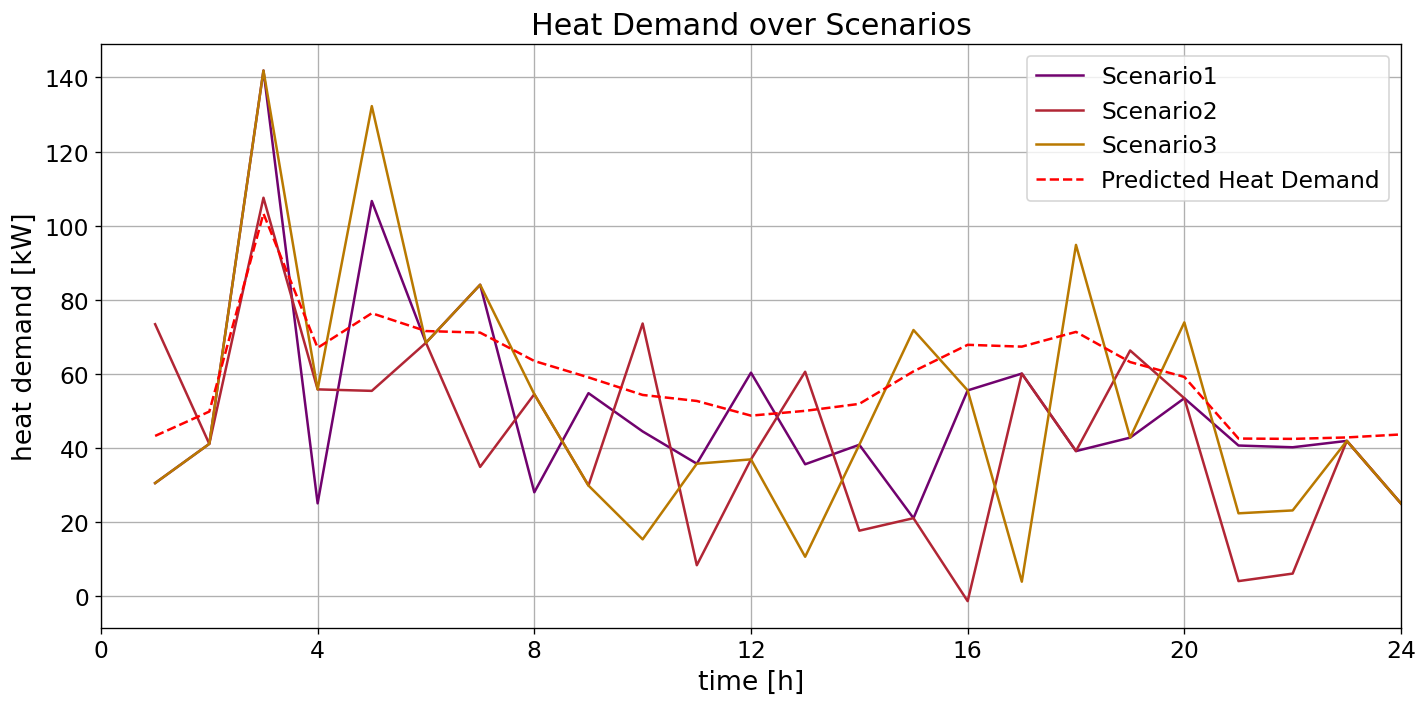

In [140]:
# Adjustable Parameters
params_to_plot = ['heat_demand_scenario']
scenarios_to_plot = ['Scenario1', 'Scenario2', 'Scenario3']  # For example, skip Scenario2
data_to_plot = []
labels = []

# Get the data to plot
for param in params_to_plot:
    for scenario in scenarios_to_plot:
        column_name = f'{scenario}.{param}'
        if column_name in combinded_df.columns:
            data_to_plot.append(combinded_df[column_name])
            labels.append(f'{scenario}')

# Get corresponding colors directly from the color mapping (fixed for each scenario)
scenario_colors = [color_mapping[scenario] for scenario in scenarios_to_plot]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Plot the scenarios
for i, data in enumerate(data_to_plot):
    ax.plot(data.index, data, label=labels[i], color=scenario_colors[i])

# Plot additional global parameters like heat_price and gas_price (with fixed colors)
ax.plot(data.index, combinded_df['Scenario1.heat_demand'], label='Predicted Heat Demand', color='red', linestyle='--')

# Set Axis Properties
set_axis_properties(ax, 'Heat Demand over Scenarios', 'heat demand [kW]', 'time [h]', fontsize_title, fontsize_label)

plt.tight_layout()
plt.show()

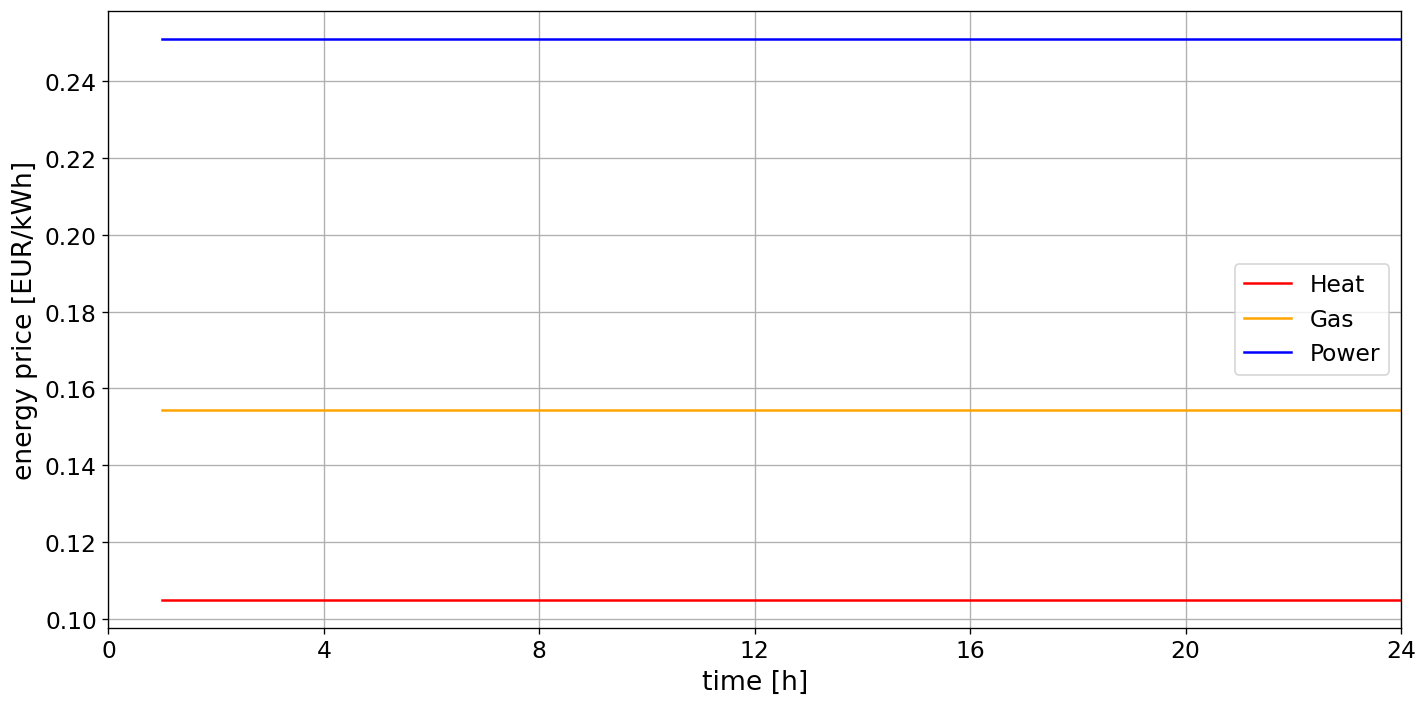

In [141]:
# List of global parameters to plot
global_params_to_plot = ['HEAT_PRICE', 'GAS_PRICE', 'POWER_PRICE']

# Mapping of the params to labels
label_mapping = {
    'HEAT_PRICE': 'Heat',
    'GAS_PRICE': 'Gas',
    'POWER_PRICE': 'Power'
}

# Set Colors
global_param_colors = [color_mapping[param] for param in global_params_to_plot]

# Create the plot for global parameters
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Plot the global parameters
for i, param in enumerate(global_params_to_plot):
    ax.plot(combinded_df.index, combinded_df[f'Scenario1.{param}'], label=label_mapping[param], color=global_param_colors[i])

# Set Axis Properties
set_axis_properties(ax, '', 'energy price [EUR/kWh]', 'time [h]', fontsize_title, fontsize_label)
ax.legend(loc=7, fontsize=fontsize_ticks)

plt.tight_layout()
plt.show()

In [142]:
combinded_df.columns.tolist()

['Scenario10.GAS_PRICE',
 'Scenario10.POWER_PRICE',
 'Scenario10.HEAT_PRICE',
 'Scenario10.heat_demand',
 'Scenario10.heat_demand_scenario',
 'Scenario10.delta_heat_demand',
 'Scenario10.probability',
 'Scenario10.chp1.bin',
 'Scenario10.chp1.power',
 'Scenario10.chp1.gas',
 'Scenario10.chp1.heat',
 'Scenario10.chp1.eta_th',
 'Scenario10.chp1.eta_el',
 'Scenario10.chp1.y1',
 'Scenario10.chp1.y2',
 'Scenario10.chp2.bin',
 'Scenario10.chp2.power',
 'Scenario10.chp2.gas',
 'Scenario10.chp2.heat',
 'Scenario10.chp2.eta_th',
 'Scenario10.chp2.eta_el',
 'Scenario10.chp2.y1',
 'Scenario10.chp2.y2',
 'Scenario10.boiler1.bin',
 'Scenario10.boiler1.heat',
 'Scenario10.boiler1.gas',
 'Scenario10.boiler1.eta_th',
 'Scenario10.boiler1.y1',
 'Scenario10.boiler1.y2',
 'Scenario10.heat_storage1.heat_charge',
 'Scenario10.heat_storage1.bin_charge',
 'Scenario10.heat_storage1.heat_discharge',
 'Scenario10.heat_storage1.bin_discharge',
 'Scenario10.heat_storage1.heat_balance',
 'Scenario10.heat_storage1.

[-114.37905085  -62.55413067    0.          -66.47636644   -8.84572265
  -13.66376827  -14.07944123   63.45810869  -26.16721038  -30.90592426
   52.66884135   48.70991175   49.99934584   51.88161483  -24.53939761
  -17.37630115  -17.86881562   71.31620716  -22.03295117   59.15634665
  -42.67852043   42.43408019  -42.37842525   43.63284969]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[157.6115883  112.35782033 103.23696639 133.49267335  85.2
  85.2         85.2          0.          85.2         85.2
   0.           0.           0.           0.          85.2
  85.2         85.2          0.          85.2          0.
  85.2          0.          85.2          0.        ]


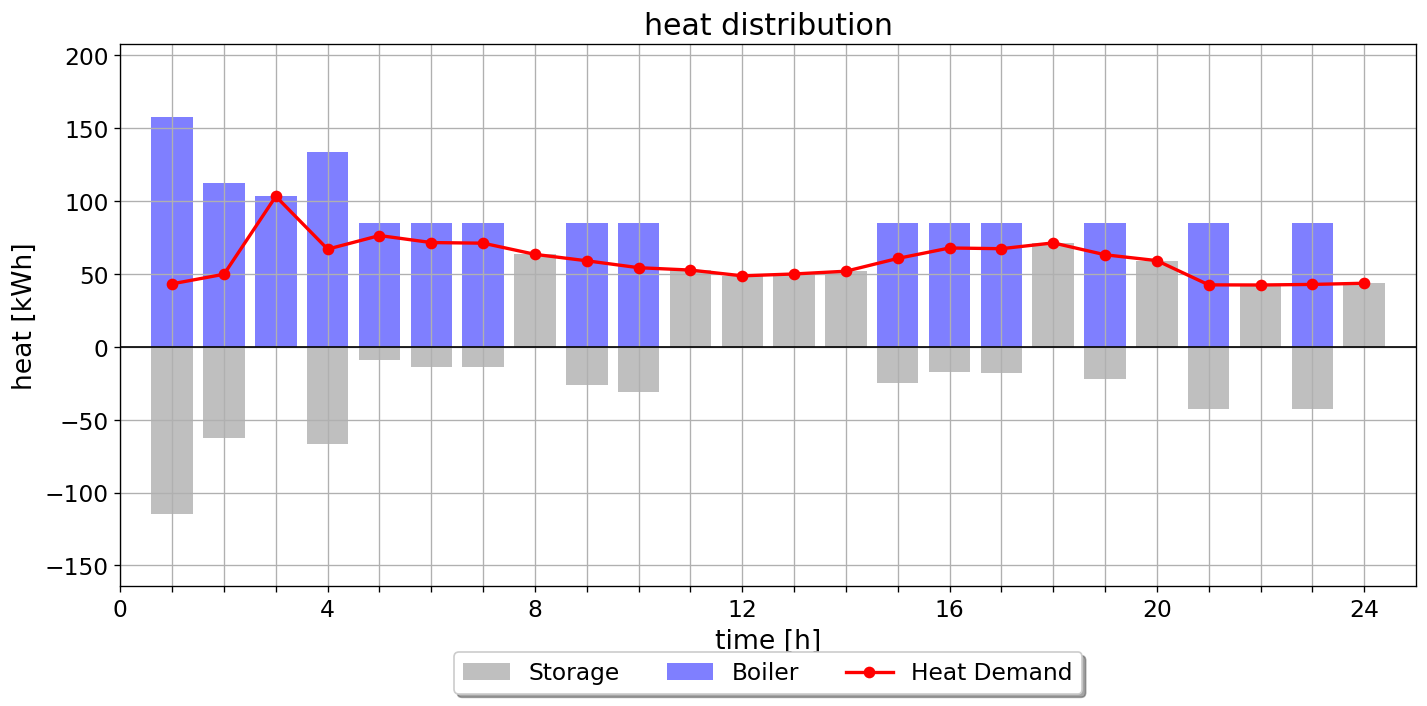

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import cmasher as cmr


# Use the index of the DataFrame as time (hours)
hours = combinded_df.index

# Extract the data
chp1 = combinded_df['Scenario1.chp1.heat']
chp2 = combinded_df['Scenario1.chp2.heat']
boiler = combinded_df['Scenario1.boiler1.heat']
storage_in = -combinded_df['Scenario1.heat_storage1.heat_charge']  # Negative for charging operations
storage_out = combinded_df['Scenario1.heat_storage1.heat_discharge']  # Positive for discharging
storage = storage_in + storage_out  # Net storage flow
hd = combinded_df['Scenario1.heat_demand']  # Heat demand (line plot)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6), dpi=120)

# Initialize cumulative sums for stacking
pos_bottom = np.zeros(len(hours))
neg_bottom = np.zeros(len(hours))

# Components to plot
components = [
    (storage, 'Storage', 'grey'),
    (chp1, 'CHP_1', 'green'),
    (chp2, 'CHP_2', 'darkrgeen'),
    (boiler, 'Boiler', 'blue'),
]

# To avoid duplicate labels in the legend
handles = []
labels = []

# Plot each component
for data_component, label, color in components:
    data_component = np.array(data_component)
    print(data_component)
    # Separate positive and negative values
    pos_values = np.where(data_component > 0, data_component, 0)
    neg_values = np.where(data_component < 0, data_component, 0)
    # Plot positive values
    if np.any(pos_values):
        bars = ax.bar(hours, pos_values, bottom=pos_bottom, color=color, alpha=0.5)
        pos_bottom += pos_values
        # Only add label if not already added
        if label not in labels:
            handles.append(bars[0])
            labels.append(label)
    # Plot negative values
    if np.any(neg_values):
        bars = ax.bar(hours, neg_values, bottom=neg_bottom, color=color, alpha=0.5)
        neg_bottom += neg_values
        # Only add label if not already added
        if label not in labels:
            handles.append(bars[0])
            labels.append(label)

# Plot the line for Heat Demand
line_hd, = ax.plot(hours, hd, label='Heat Demand', color='red', marker='o', linewidth=2)
handles.append(line_hd)
labels.append('Heat Demand')

# Add horizontal line at y=0
ax.axhline(0, color='black', linewidth=1)

# Set axis labels and title
# Set Axis Properties
set_axis_properties(ax, 'heat distribution', 'heat [kWh]', 'time [h]', fontsize_title, fontsize_label)

# Adjust the grid, ticks, and axis limits
ax.grid(True)
ax.set_xticks(np.arange(0, 25, 1))  # X-axis with hours
ax.set_xlim([0, 25])  # Set the X range
ax.set_ylim([neg_bottom.min() - 50, pos_bottom.max() + 50])  # Adjust Y range based on data
ax.tick_params(axis='both', labelsize=fontsize_ticks)

# Add the legend
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, fontsize=fontsize_ticks)

# Show the plot
plt.tight_layout()
plt.show() 

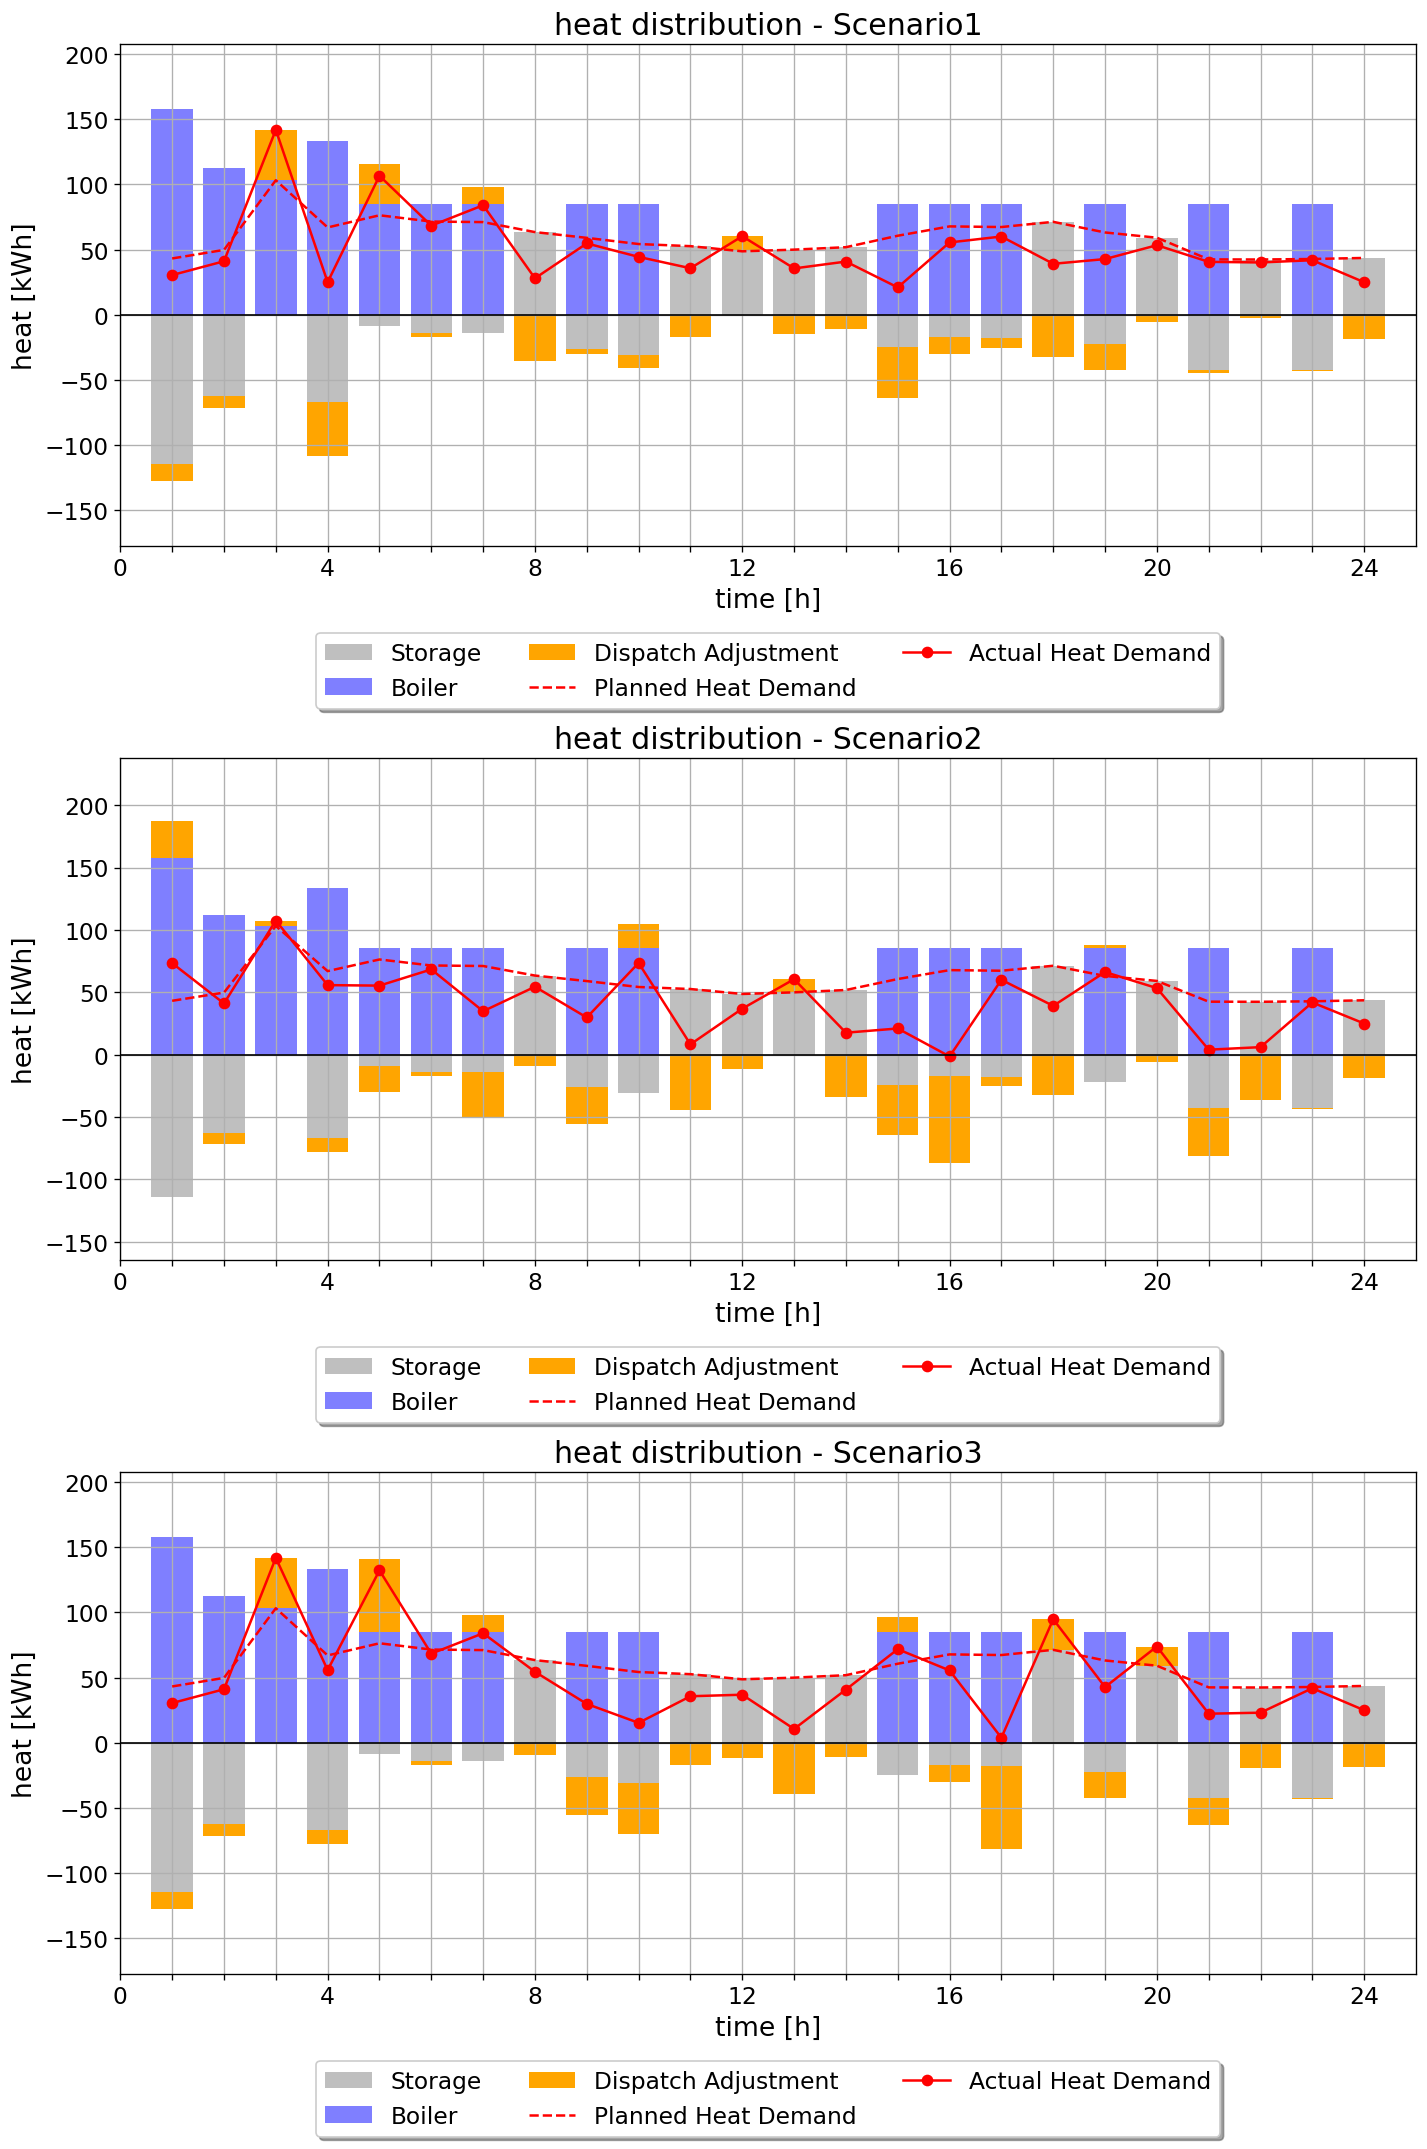

In [144]:
import matplotlib.pyplot as plt
import numpy as np
import cmasher as cmr

# Use the index of the DataFrame as time (hours)
hours = combinded_df.index

# Extract the first-stage data (common across scenarios)
chp1 = combinded_df['Scenario1.chp1.heat']
chp2 = combinded_df['Scenario1.chp2.heat']
boiler = combinded_df['Scenario1.boiler1.heat']
storage_in = -combinded_df['Scenario1.heat_storage1.heat_charge']  # Negative for charging operations
storage_out = combinded_df['Scenario1.heat_storage1.heat_discharge']  # Positive for discharging
storage = storage_in + storage_out  # Net storage flow
planned_hd = combinded_df['Scenario1.heat_demand']  # Planned heat demand

# Components for first-stage plot
first_stage_components = [
    (storage, 'Storage', 'grey'),
    (chp1, 'CHP_1', 'green'),
    (chp2, 'CHP_2', 'darkrgeen'),
    (boiler, 'Boiler', 'blue'),
]

# Number of scenarios
scenarios = ['Scenario1', 'Scenario2', 'Scenario3']  # Add more scenarios as needed

# Set up the figure with subplots
fig, axes = plt.subplots(nrows=len(scenarios), ncols=1, figsize=(12, 6 * len(scenarios)), dpi=120)

# If there's only one scenario, axes might not be an array
if len(scenarios) == 1:
    axes = [axes]

for ax, scenario in zip(axes, scenarios):
    # Extract second-stage data for the scenario
    dispatch = combinded_df[f'{scenario}.heat_storage1.dispatch']  # Net dispatch
    dispatch_charge = -combinded_df[f'{scenario}.heat_storage1.dispatch_delta_heat_charge']  # Negative for charging
    dispatch_discharge = combinded_df[f'{scenario}.heat_storage1.dispatch_delta_heat_discharge']  # Positive for discharging
    actual_hd = combinded_df[f'{scenario}.heat_demand_scenario']  # Actual heat demand for the scenario

    # Initialize cumulative sums for stacking
    pos_bottom = np.zeros(len(hours))
    neg_bottom = np.zeros(len(hours))

    # Plot first-stage components
    handles = []
    labels = []
    for data_component, label, color in first_stage_components:
        data_component = np.array(data_component)
        # Separate positive and negative values
        pos_values = np.where(data_component > 0, data_component, 0)
        neg_values = np.where(data_component < 0, data_component, 0)
        # Plot positive values
        if np.any(pos_values):
            bars = ax.bar(hours, pos_values, bottom=pos_bottom, color=color, alpha=0.5)
            pos_bottom += pos_values
            if label not in labels:
                handles.append(bars[0])
                labels.append(label)
        # Plot negative values
        if np.any(neg_values):
            bars = ax.bar(hours, neg_values, bottom=neg_bottom, color=color, alpha=0.5)
            neg_bottom += neg_values
            if label not in labels:
                handles.append(bars[0])
                labels.append(label)

    # Plot second-stage adjustments (dispatch)
    # We'll plot the adjustments as an overlay on top of the first-stage storage component
    dispatch_total = dispatch_charge + dispatch_discharge
    # Separate positive and negative adjustments
    dispatch_pos = np.where(dispatch_total > 0, dispatch_total, 0)
    dispatch_neg = np.where(dispatch_total < 0, dispatch_total, 0)
    # Plot positive adjustments
    if np.any(dispatch_pos):
        bars = ax.bar(hours, dispatch_pos, bottom=pos_bottom, color='orange', label='Dispatch Adjustment')
        pos_bottom += dispatch_pos
        if 'Dispatch Adjustment' not in labels:
            handles.append(bars[0])
            labels.append('Dispatch Adjustment')
    # Plot negative adjustments
    if np.any(dispatch_neg):
        bars = ax.bar(hours, dispatch_neg, bottom=neg_bottom, color='orange')
        neg_bottom += dispatch_neg

    # Plot planned and actual heat demand
    line_planned, = ax.plot(hours, planned_hd, label='Planned Heat Demand', color='red', linestyle='--')
    line_actual, = ax.plot(hours, actual_hd, label='Actual Heat Demand', color='red', marker='o')
    handles.extend([line_planned, line_actual])
    labels.extend(['Planned Heat Demand', 'Actual Heat Demand'])

    # Add horizontal line at y=0
    ax.axhline(0, color='black', linewidth=1)

    # Set axis labels and title
    set_axis_properties(ax, f'heat distribution - {scenario}', 'heat [kWh]', 'time [h]', fontsize_title, fontsize_label)

    # Adjust the grid, ticks, and axis limits
    ax.grid(True)
    ax.set_xticks(np.arange(0, 25, 1))  # X-axis with hours
    ax.set_xlim([0, 25])  # Set the X range
    y_min = min(neg_bottom.min(), dispatch_neg.min(), -50)
    y_max = max(pos_bottom.max(), dispatch_pos.max(), 50)
    ax.set_ylim([y_min - 50, y_max + 50])  # Adjust Y range based on data
    ax.tick_params(axis='both', labelsize=fontsize_ticks)

    # Add the legend
    ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15),
              fancybox=True, shadow=True, ncol=3, fontsize=fontsize_ticks)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
